In [ ]:
import tensorflow as tf
print(tf.__version__)

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Setting of the main hyper-parameters of the model

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

In [4]:
SAVE_PATH = "C:/Users/Mr Laptop/OneDrive/Desktop/git/pennylane_project/womanium-pennylane-project/task_3"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [5]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [14]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)




Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


In [15]:
# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

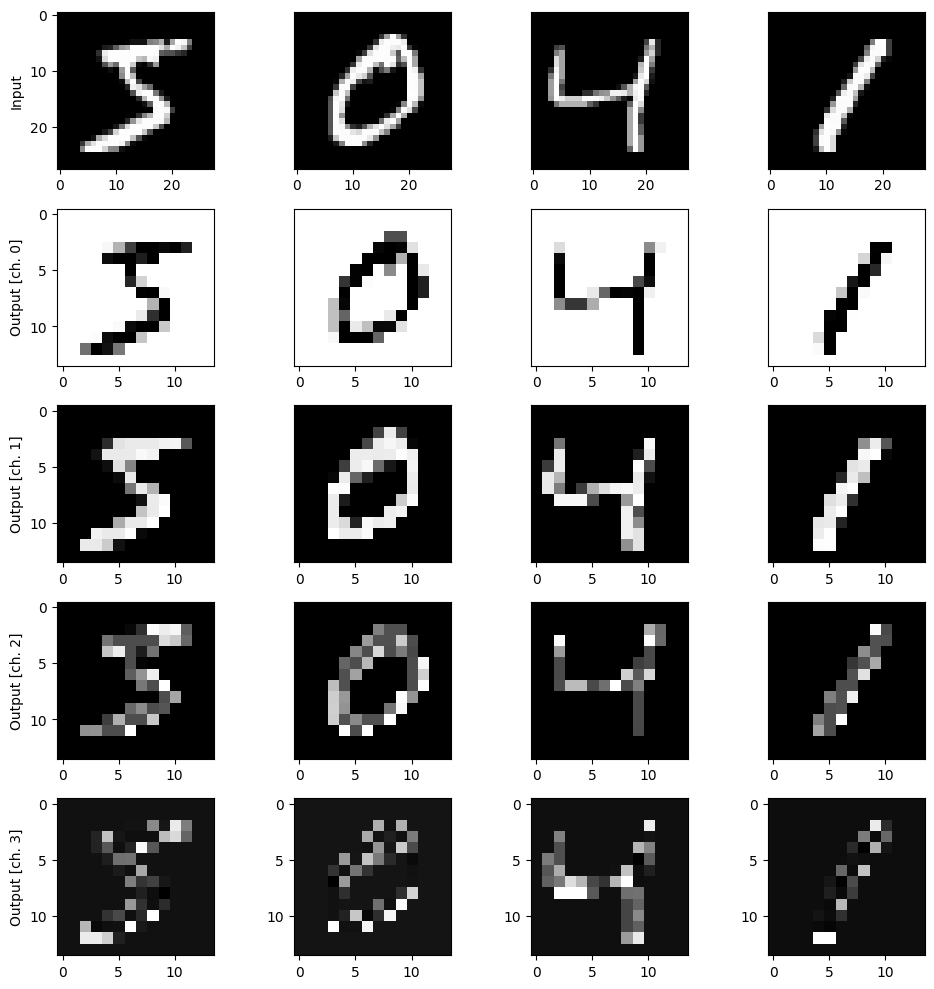

In [16]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [17]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [18]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 145ms/step - accuracy: 0.1600 - loss: 2.7775 - val_accuracy: 0.2000 - val_loss: 2.1565
Epoch 2/30
13/13 - 0s - 16ms/step - accuracy: 0.4000 - loss: 1.9984 - val_accuracy: 0.2333 - val_loss: 1.9981
Epoch 3/30
13/13 - 0s - 15ms/step - accuracy: 0.6200 - loss: 1.6519 - val_accuracy: 0.3667 - val_loss: 1.8477
Epoch 4/30
13/13 - 0s - 16ms/step - accuracy: 0.7200 - loss: 1.3351 - val_accuracy: 0.5333 - val_loss: 1.6764
Epoch 5/30
13/13 - 0s - 14ms/step - accuracy: 0.8200 - loss: 1.0940 - val_accuracy: 0.6667 - val_loss: 1.5465
Epoch 6/30
13/13 - 0s - 13ms/step - accuracy: 0.9000 - loss: 0.8988 - val_accuracy: 0.6667 - val_loss: 1.4588
Epoch 7/30
13/13 - 0s - 13ms/step - accuracy: 0.9600 - loss: 0.7493 - val_accuracy: 0.7667 - val_loss: 1.3834
Epoch 8/30
13/13 - 0s - 14ms/step - accuracy: 0.9800 - loss: 0.6329 - val_accuracy: 0.7667 - val_loss: 1.3195
Epoch 9/30
13/13 - 0s - 14ms/step - accuracy: 0.9800 - loss: 0.5400 - val_accuracy: 0.7667 - val_loss: 1.2698
Epoch 10/

In [19]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 133ms/step - accuracy: 0.0400 - loss: 2.4617 - val_accuracy: 0.1667 - val_loss: 2.3512
Epoch 2/30
13/13 - 0s - 15ms/step - accuracy: 0.4400 - loss: 2.0225 - val_accuracy: 0.1667 - val_loss: 2.2161
Epoch 3/30
13/13 - 0s - 14ms/step - accuracy: 0.5800 - loss: 1.7255 - val_accuracy: 0.2667 - val_loss: 2.0912
Epoch 4/30
13/13 - 0s - 15ms/step - accuracy: 0.7200 - loss: 1.4848 - val_accuracy: 0.3667 - val_loss: 1.9680
Epoch 5/30
13/13 - 0s - 13ms/step - accuracy: 0.8200 - loss: 1.2823 - val_accuracy: 0.4000 - val_loss: 1.8542
Epoch 6/30
13/13 - 0s - 13ms/step - accuracy: 0.8800 - loss: 1.1125 - val_accuracy: 0.4667 - val_loss: 1.7558
Epoch 7/30
13/13 - 0s - 13ms/step - accuracy: 0.9200 - loss: 0.9711 - val_accuracy: 0.4667 - val_loss: 1.6733
Epoch 8/30
13/13 - 0s - 14ms/step - accuracy: 0.9400 - loss: 0.8531 - val_accuracy: 0.5333 - val_loss: 1.6043
Epoch 9/30
13/13 - 0s - 12ms/step - accuracy: 0.9800 - loss: 0.7540 - val_accuracy: 0.5667 - val_loss: 1.5461
Epoch 10/

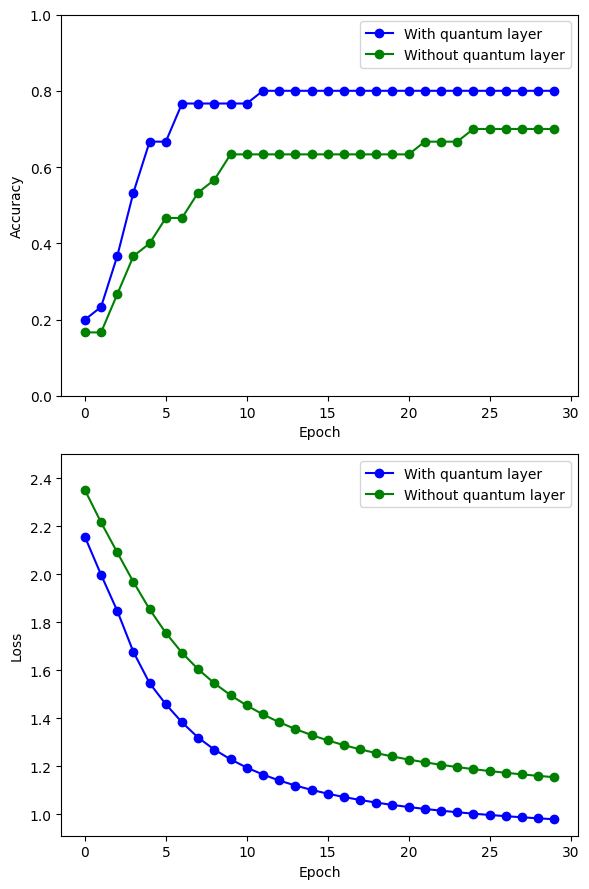

In [28]:
import matplotlib.pyplot as plt

plt.style.use("fast")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [26]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
